In [2]:
#### script to be used with Synergy plate reader

In [1]:
# Load packages
library(dplyr)
library(tidyr)
library(hms)
library(lubridate)
library(ggplot2)
library(purrr)
library(patchwork)
library(tidyverse)
# library(reshape2)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following object is masked from ‘package:hms’:

    hms


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.1     ✔ stringr 1.5.2
✔ readr   2.1.5     ✔ tibble  3.3.0
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ lubridate::hms() masks hms::hms()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://con

In [2]:
# Import timepoint 0h
raw <- read.csv("od600_tp0.csv", header = FALSE , skip = 1, na.strings = c("", "NA"))

# Make first column into row names
rownames(raw) <- raw$V1
raw <- raw[, -1]   # drop V1 now that it's row names

# Rename columns as 1–12
colnames(raw) <- as.character(1:12)
head(raw)

# Convert rownames into a column
raw2 <- raw %>%
  tibble::rownames_to_column("Row")

# Pivot longer to get Row + Column + Value
long <- raw2 %>%
  pivot_longer(-Row, names_to = "Col", values_to = "Value") %>%
  mutate(Well = paste0(Row, Col)) %>%
  select(Well, Value)

# keep only non-NA values
long <- long %>% filter(!is.na(Value) & Value != "<NA>") 

head(long)

# Convert decimal commas to numeric with dots
long$Value <- as.numeric(gsub(",", ".", long$Value))

# Transpose into wide format: one row with wells as columns
wide <- long %>%
  pivot_wider(names_from = Well, values_from = Value)

# Add Time column at the front
wide <- wide %>%
  mutate(Time = "00:00:00", .before = 1)

head(wide)

,1,2,3,4,5,6,7,8,9,10,11,12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,0.084,0.083,0.085,0.085,0.085,0.086,0.086,0.084,0.084,0.084,0.085,0.086
B,0.084,0.092,0.092,0.093,0.089,0.091,0.089,0.093,0.090,0.093,0.087,0.107
C,0.084,0.090,0.092,0.092,0.091,0.091,0.090,0.093,0.092,0.089,0.095,0.086
D,0.085,0.095,0.093,0.095,0.090,0.089,0.092,0.141,0.098,0.101,0.088,0.086
E,0.085,0.093,0.097,0.100,0.092,0.092,0.091,0.096,0.096,0.097,0.087,0.084
F,0.086,0.093,0.093,0.092,0.090,0.091,0.090,0.088,0.124,0.112,0.087,0.084


Well,Value
<chr>,<dbl>
A1,0.084
A2,0.083
A3,0.085
A4,0.085
A5,0.085
A6,0.086


Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,⋯,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00:00:00,0.084,0.083,0.085,0.085,0.085,0.086,0.086,0.084,0.084,⋯,0.085,0.085,0.084,0.093,0.087,0.085,0.086,0.085,0.086,0.084


In [3]:
# Import and process incubation measures
od_tp <- read_tsv("od600_tp.tsv", col_types = cols(.default = "c"))
od_tp <- od_tp %>%
  mutate(across(-Time, ~ as.numeric(gsub(",", ".", .))))

head(od_tp)

Time,T° 600,A1,A2,A3,A4,A5,A6,A7,A8,⋯,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0:29:35,37,0.084,0.084,0.085,0.086,0.085,0.086,0.086,0.085,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.086,0.085,0.086,0.084
0:59:35,37,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.087,0.085,0.086,0.084
1:29:35,37,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.087,0.085,0.086,0.084
1:59:35,37,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.086,⋯,0.085,0.085,0.085,0.093,0.086,0.085,0.087,0.085,0.087,0.084
2:29:35,37,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,⋯,0.085,0.085,0.085,0.093,0.087,0.085,0.086,0.085,0.086,0.084
2:59:35,37,0.084,0.085,0.085,0.086,0.085,0.087,0.086,0.086,⋯,0.085,0.085,0.085,0.093,0.087,0.085,0.087,0.085,0.086,0.084


In [4]:
# Remove temperature column if present 
column_name <- "T° 600"

if (column_name %in% names(od_tp)) {
  od_tp <- subset(od_tp, select = -get(column_name))
  print(paste("Column '", column_name, "' removed.", sep = ""))
} else {
  print(paste("Column '", column_name, "' not found.", sep = ""))
}

head(od_tp)

[1] "Column 'T° 600' removed."


Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,⋯,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0:29:35,0.084,0.084,0.085,0.086,0.085,0.086,0.086,0.085,0.084,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.086,0.085,0.086,0.084
0:59:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,0.084,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.087,0.085,0.086,0.084
1:29:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,0.084,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.087,0.085,0.086,0.084
1:59:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.086,0.084,⋯,0.085,0.085,0.085,0.093,0.086,0.085,0.087,0.085,0.087,0.084
2:29:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,0.085,⋯,0.085,0.085,0.085,0.093,0.087,0.085,0.086,0.085,0.086,0.084
2:59:35,0.084,0.085,0.085,0.086,0.085,0.087,0.086,0.086,0.085,⋯,0.085,0.085,0.085,0.093,0.087,0.085,0.087,0.085,0.086,0.084


In [5]:
# Combine both dataframes
first_row <- wide[1, ] # take first row
combined_od <- rbind(first_row, od_tp) # copy it up top on od_tp
head(combined_od)

Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,⋯,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00:00:00,0.084,0.083,0.085,0.085,0.085,0.086,0.086,0.084,0.084,⋯,0.085,0.085,0.084,0.093,0.087,0.085,0.086,0.085,0.086,0.084
0:29:35,0.084,0.084,0.085,0.086,0.085,0.086,0.086,0.085,0.084,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.086,0.085,0.086,0.084
0:59:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,0.084,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.087,0.085,0.086,0.084
1:29:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,0.084,⋯,0.085,0.085,0.084,0.093,0.086,0.085,0.087,0.085,0.086,0.084
1:59:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.086,0.084,⋯,0.085,0.085,0.085,0.093,0.086,0.085,0.087,0.085,0.087,0.084
2:29:35,0.084,0.084,0.085,0.086,0.085,0.087,0.086,0.085,0.085,⋯,0.085,0.085,0.085,0.093,0.087,0.085,0.086,0.085,0.086,0.084


In [6]:
od_tp <- combined_od

In [7]:
# --- Helper function to reshape and annotate ---
reshape_od <- function(df) {
  df %>%
    pivot_longer(-Time, names_to = "Well", values_to = "OD") %>%
    mutate(
      Well = str_trim(Well),
      Row = str_extract(Well, "^[A-H]"),
      Col = as.numeric(str_extract(Well, "\\d+")),
      
      # --- Strains by column ---
      Strain = case_when(
        Col %in% c(2, 3, 4)  ~ "HC-B1",
        Col %in% c(5, 6, 7)  ~ "AD04",
        Col %in% c(8, 9, 10) ~ "AD11",
        TRUE ~ NA_character_
      ),
      
      # --- Carbons by row ---
      Carbon = case_when(
        Row == "B" ~ "Sia_0.4%",
        Row == "C" ~ "Sia_0.2%",
        Row == "D" ~ "Sia_0.1%",
        Row == "E" ~ "Sia_0.05%",
        Row == "F" ~ "Glu_0.4%",
        Row == "G" ~ "Blank",
        TRUE ~ NA_character_
      ),
      
      OD = as.numeric(OD)
    )
}

# Apply to your single plate
od_long <- reshape_od(od_tp)

In [8]:
head(od_long)
tail(od_long)

Time,Well,OD,Row,Col,Strain,Carbon
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
00:00:00,A1,0.084,A,1,NA,NA
00:00:00,A2,0.083,A,2,HC-B1,NA
00:00:00,A3,0.085,A,3,HC-B1,NA
00:00:00,A4,0.085,A,4,HC-B1,NA
00:00:00,A5,0.085,A,5,AD04,NA
00:00:00,A6,0.086,A,6,AD04,NA


Time,Well,OD,Row,Col,Strain,Carbon
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
30:29:35,H7,0.086,H,7,AD04,NA
30:29:35,H8,0.086,H,8,AD11,NA
30:29:35,H9,0.088,H,9,AD11,NA
30:29:35,H10,0.085,H,10,AD11,NA
30:29:35,H11,0.086,H,11,NA,NA
30:29:35,H12,0.084,H,12,NA,NA


In [9]:
write_tsv(od_long, "od_long151025.tsv")

In [10]:
# Remove unwanted wells
# od_long <- od_long %>%
#   filter(
#     !Row %in% c("A", "H"),        # remove top/bottom rows
#     !Col %in% c(1, 11, 12),           # remove side columns
#     !is.na(Carbon),               # ensure only real wells
#     !is.na(Strain)
#   )

# Remove unwanted wells
od_long <- od_long %>%
  filter(
    !Row %in% c("A", "H"),        # remove top/bottom rows
    !Col %in% c(1, 12),           # remove side columns
    !is.na(Carbon),               # ensure only real wells
    !is.na(Strain)
  )

In [11]:
head(od_long)
tail(od_long)

Time,Well,OD,Row,Col,Strain,Carbon
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
00:00:00,B2,0.092,B,2,HC-B1,Sia_0.4%
00:00:00,B3,0.092,B,3,HC-B1,Sia_0.4%
00:00:00,B4,0.093,B,4,HC-B1,Sia_0.4%
00:00:00,B5,0.089,B,5,AD04,Sia_0.4%
00:00:00,B6,0.091,B,6,AD04,Sia_0.4%
00:00:00,B7,0.089,B,7,AD04,Sia_0.4%


Time,Well,OD,Row,Col,Strain,Carbon
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
30:29:35,G5,0.089,G,5,AD04,Blank
30:29:35,G6,0.088,G,6,AD04,Blank
30:29:35,G7,0.089,G,7,AD04,Blank
30:29:35,G8,0.089,G,8,AD11,Blank
30:29:35,G9,0.089,G,9,AD11,Blank
30:29:35,G10,0.088,G,10,AD11,Blank


In [12]:
# Make time purely numeric
od_long$Time <- time_length(hms(od_long$Time), unit = "hour")

In [13]:
# Check if all conditions have 3 replicas
replica_counts <- od_long %>%
  group_by(Strain, Carbon, Time) %>%
  summarise(n_replicates = n(), .groups = "drop") %>%
  filter(n_replicates != 3) # we'll only print out those that don't have 3 replicas

replica_counts

Strain,Carbon,Time,n_replicates
<chr>,<chr>,<dbl>,<int>


In [14]:
head(od_long)

Time,Well,OD,Row,Col,Strain,Carbon
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,B2,0.092,B,2,HC-B1,Sia_0.4%
0,B3,0.092,B,3,HC-B1,Sia_0.4%
0,B4,0.093,B,4,HC-B1,Sia_0.4%
0,B5,0.089,B,5,AD04,Sia_0.4%
0,B6,0.091,B,6,AD04,Sia_0.4%
0,B7,0.089,B,7,AD04,Sia_0.4%


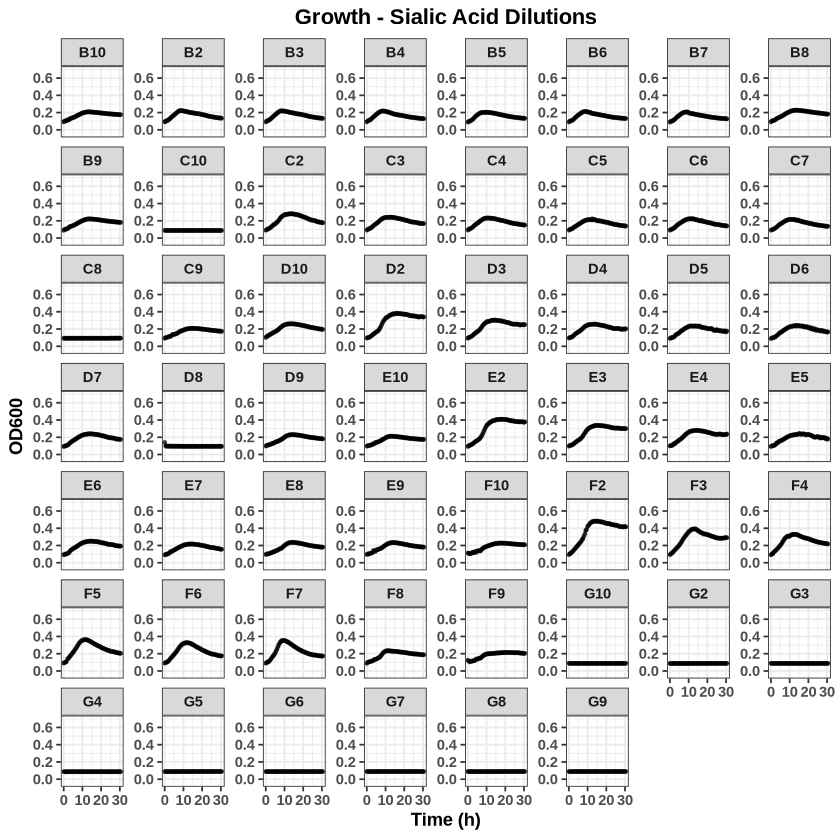

In [19]:
a <- ggplot(od_long, aes(x = Time, y = OD)) +
  geom_point(size = 0.7, alpha = 0.6) +
  geom_line(alpha = 0.6) +
  facet_wrap(~Well, scales = "free_y") +
  labs(
    x = "Time (h)",
    y = "OD600",
    title = "Growth - Sialic Acid Dilutions"
  ) +
  scale_y_continuous(limits = c(-0.05, 0.7)) +
  theme_bw() +
  theme(
    text = element_text(face = "bold"),            # all text bold
    strip.text = element_text(face = "bold"),      # facet labels bold
    axis.title = element_text(face = "bold"),      # axis titles bold
    axis.text = element_text(face = "bold"),       # axis numbers bold
    plot.title = element_text(face = "bold", hjust = 0.5) # center + bold title
  )
a

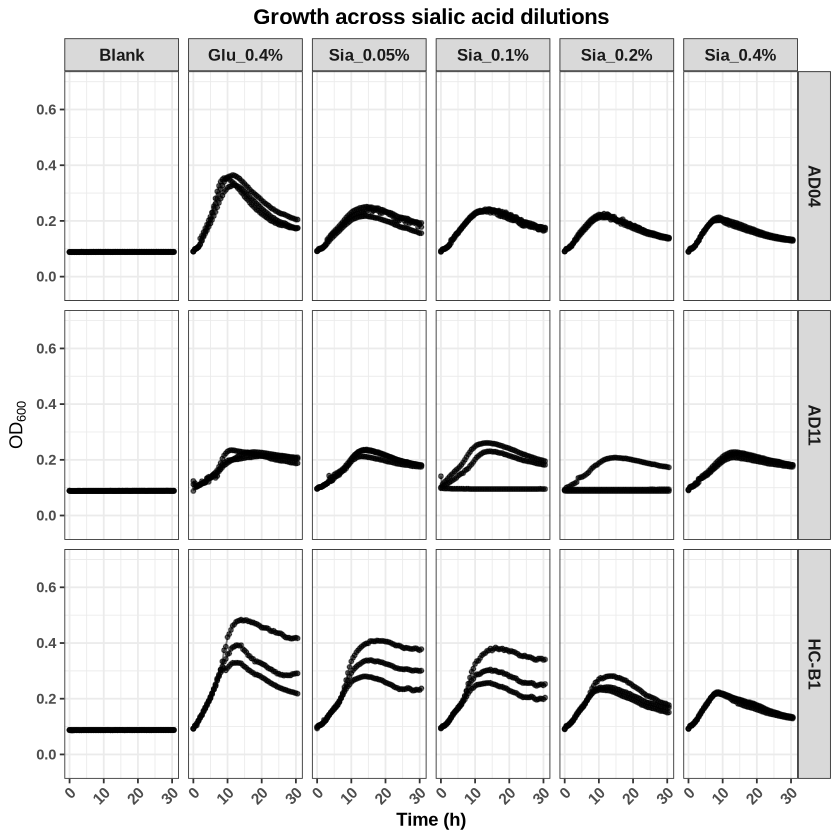

In [20]:
growth_plotA <- ggplot(od_long, aes(x = Time, y = OD, group = Well)) +
  geom_point(size = 1, alpha = 0.6) +
  geom_line(alpha = 0.5) +
  facet_grid(Strain ~ Carbon, scales = "free_y") +
  labs(
    x = "Time (h)",
    y = expression(OD[600]),
    title = "Growth across sialic acid dilutions"
  ) +
  scale_y_continuous(limits = c(-0.05, 0.7)) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(face = "bold", hjust = 0.5),
    strip.text = element_text(size = 10, face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold")
  )

growth_plotA

Warning message in geom_point(aes(group = Well), color = "lightgray", linewidth = 1, :
“Ignoring unknown parameters: `linewidth`”
`geom_smooth()` using formula = 'y ~ x'


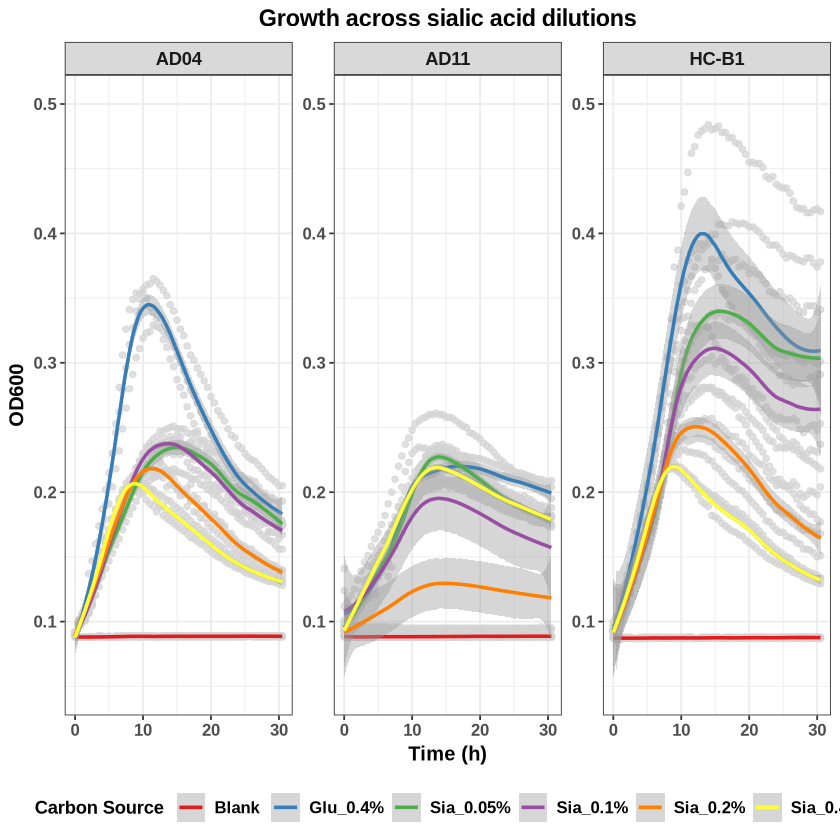

In [18]:
plotA <- ggplot(od_long, aes(x = Time, y = OD)) +
  # Raw measurements in light gray
  geom_point(aes(group = Well), color = "lightgray", linewidth = 1.0, alpha = 0.7) +
  # Loess trend colored by Carbon
  geom_smooth(aes(color = Carbon, group = Carbon), 
              method = "loess", span = 0.3, se = TRUE, size = 1) +
  facet_wrap(~Strain, scales = "free_y") +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = "Time (h)",
    y = "OD600",
    color = "Carbon Source",
    title = "Growth across sialic acid dilutions"
  ) +
  scale_y_continuous(limits = c(0.05, 0.5)) +  # fix y-axis across all facets
  # coord_cartesian(xlim = c(0, 40)) +   # <- limits to 0–40h but keeps smoothing intact
  theme_bw() +
  theme(
    legend.position = "bottom", 
    axis.title = element_text(face = "bold", size = 12),
    axis.text = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    legend.title = element_text(face = "bold", size = 11),
    legend.text = element_text(face = "bold", size = 10),
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5), # centered bold title
    legend.box = "horizontal" # ensures legend items flow horizontally
  ) +
  guides(color = guide_legend(nrow = 1, byrow = TRUE))

plotA

In [19]:
ggsave("growth_curves_Sia_dilutions.png", plotA, width = 12, height = 6, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'


In [3]:
#### script to be used with Synergy plate reader

In [6]:
# Import and process incubation measures
od_tp <- read_tsv("od600_tp_EPOCH2.tsv", col_types = cols(.default = "c"))
tail(od_tp)

Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,⋯,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
22:59:16,0.085,0.084,0.085,0.085,0.085,0.082,0.082,0.086,0.084,⋯,0.083,0.088,0.111,0.084,0.084,0.087,0.084,0.087,0.086,0.086
23:59:16,0.085,0.085,0.085,0.085,0.085,0.083,0.082,0.087,0.084,⋯,0.084,0.088,0.111,0.085,0.085,0.087,0.084,0.087,0.086,0.086
24:59:16,0.085,0.084,0.085,0.084,0.085,0.083,0.082,0.086,0.084,⋯,0.083,0.088,0.11,0.085,0.084,0.087,0.083,0.087,0.086,0.086
25:59:16,0.085,0.084,0.085,0.084,0.085,0.083,0.082,0.086,0.084,⋯,0.083,0.087,0.11,0.084,0.084,0.087,0.084,0.086,0.085,0.086
26:59:16,0.085,0.084,0.085,0.084,0.085,0.083,0.083,0.087,0.084,⋯,0.084,0.089,0.111,0.086,0.085,0.088,0.084,0.087,0.086,0.086
27:59:16,0.085,0.084,0.085,0.085,0.085,0.083,0.083,0.087,0.085,⋯,0.084,0.088,0.11,0.086,0.085,0.088,0.084,0.087,0.086,0.086


In [7]:
# --- Helper function to reshape and annotate ---
reshape_od <- function(df) {
  df %>%
    pivot_longer(-Time, names_to = "Well", values_to = "OD") %>%
    mutate(
      Well = str_trim(Well),
      Row = str_extract(Well, "^[A-H]"),
      Col = as.numeric(str_extract(Well, "\\d+")),
      
      # --- Strains by column ---
      Strain = case_when(
        Col %in% c(2, 3, 4)  ~ "USA300",
        Col %in% c(5, 6, 7)  ~ "Newman",
        Col %in% c(8, 9, 10) ~ "SA113",
        TRUE ~ NA_character_
      ),
      
      # --- Carbons by row ---
      Carbon = case_when(
        Row == "B" ~ "Sia_0.4%",
        Row == "C" ~ "Sia_0.2%",
        Row == "D" ~ "Sia_0.1%",
        Row == "E" ~ "Sia_0.05%",
        Row == "F" ~ "Glu_0.4%",
        Row == "G" ~ "Blank",
        TRUE ~ NA_character_
      ),
      
      OD = as.numeric(OD)
    )
}


In [8]:
# Apply to your single plate
od_long <- reshape_od(od_tp)

# Remove unwanted wells
od_long <- od_long %>%
  filter(
    !Row %in% c("A", "H"),        # remove top/bottom rows
    !Col %in% c(1, 12),           # remove side columns
    !is.na(Carbon),               # ensure only real wells
    !is.na(Strain)
  )
  
head(od_long)
tail(od_long)

Time,Well,OD,Row,Col,Strain,Carbon
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0:00:00,B2,0.107,B,2,USA300,Sia_0.4%
0:00:00,B3,0.087,B,3,USA300,Sia_0.4%
0:00:00,B4,0.107,B,4,USA300,Sia_0.4%
0:00:00,B5,0.110,B,5,Newman,Sia_0.4%
0:00:00,B6,0.105,B,6,Newman,Sia_0.4%
0:00:00,B7,0.088,B,7,Newman,Sia_0.4%


Time,Well,OD,Row,Col,Strain,Carbon
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
27:59:16,G5,0.091,G,5,Newman,Blank
27:59:16,G6,0.094,G,6,Newman,Blank
27:59:16,G7,0.087,G,7,Newman,Blank
27:59:16,G8,0.088,G,8,SA113,Blank
27:59:16,G9,0.087,G,9,SA113,Blank
27:59:16,G10,0.089,G,10,SA113,Blank


In [9]:
# Make time purely numeric
od_long$Time <- time_length(hms(od_long$Time), unit = "hour")

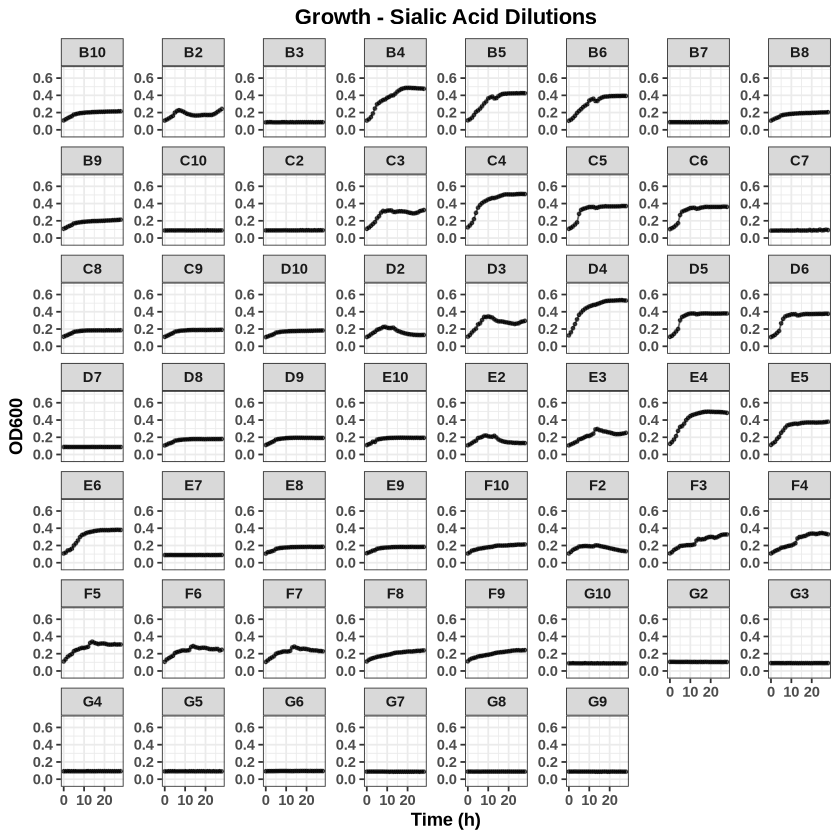

In [10]:
a <- ggplot(od_long, aes(x = Time, y = OD)) +
  geom_point(size = 0.7, alpha = 0.6) +
  geom_line(alpha = 0.6) +
  facet_wrap(~Well, scales = "free_y") +
  labs(
    x = "Time (h)",
    y = "OD600",
    title = "Growth - Sialic Acid Dilutions"
  ) +
  scale_y_continuous(limits = c(-0.05, 0.7)) +
  theme_bw() +
  theme(
    text = element_text(face = "bold"),            # all text bold
    strip.text = element_text(face = "bold"),      # facet labels bold
    axis.title = element_text(face = "bold"),      # axis titles bold
    axis.text = element_text(face = "bold"),       # axis numbers bold
    plot.title = element_text(face = "bold", hjust = 0.5) # center + bold title
  )
a

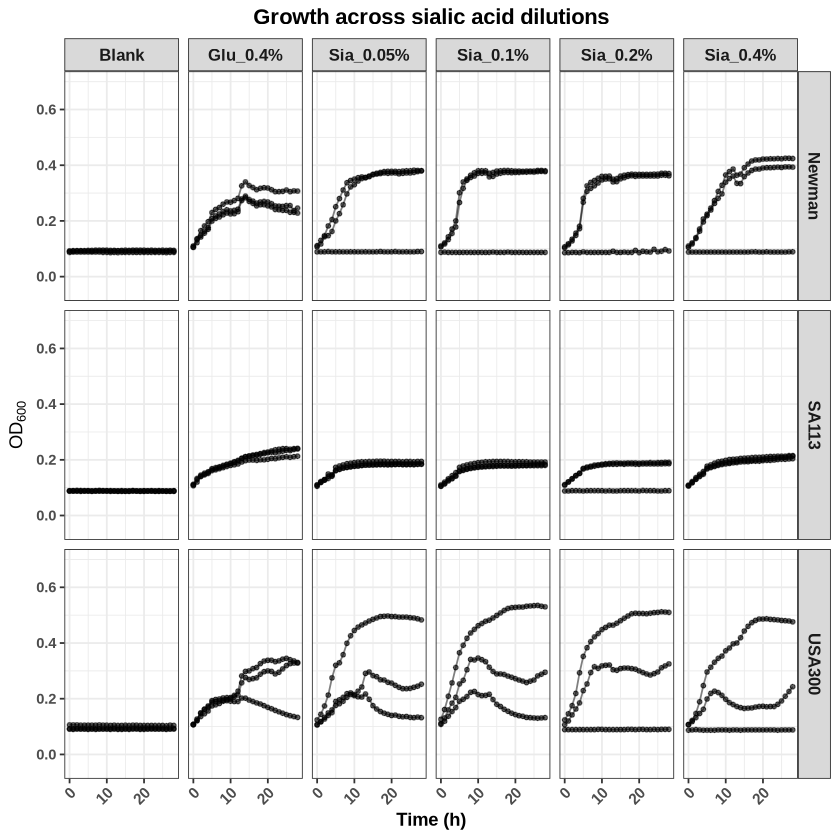

In [11]:
growth_plotA <- ggplot(od_long, aes(x = Time, y = OD, group = Well)) +
  geom_point(size = 1, alpha = 0.6) +
  geom_line(alpha = 0.5) +
  facet_grid(Strain ~ Carbon, scales = "free_y") +
  labs(
    x = "Time (h)",
    y = expression(OD[600]),
    title = "Growth across sialic acid dilutions"
  ) +
  scale_y_continuous(limits = c(-0.05, 0.7)) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(face = "bold", hjust = 0.5),
    strip.text = element_text(size = 10, face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold")
  )

growth_plotA


Warning message in geom_point(aes(group = Well), color = "lightgray", linewidth = 1, :
“Ignoring unknown parameters: `linewidth`”
`geom_smooth()` using formula = 'y ~ x'


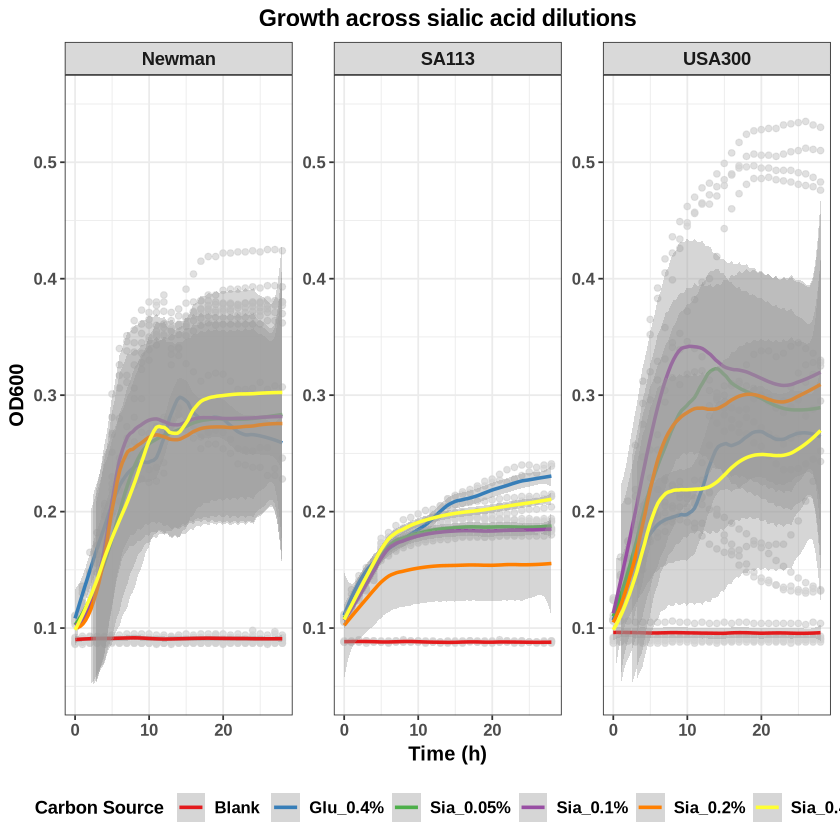

In [15]:
plotA <- ggplot(od_long, aes(x = Time, y = OD)) +
  # Raw measurements in light gray
  geom_point(aes(group = Well), color = "lightgray", linewidth = 1.0, alpha = 0.7) +
  # Loess trend colored by Carbon
  geom_smooth(aes(color = Carbon, group = Carbon), 
              method = "loess", span = 0.3, se = TRUE, size = 1) +
  facet_wrap(~Strain, scales = "free_y") +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = "Time (h)",
    y = "OD600",
    color = "Carbon Source",
    title = "Growth across sialic acid dilutions"
  ) +
  scale_y_continuous(limits = c(0.05, 0.55)) +  # fix y-axis across all facets
  # coord_cartesian(xlim = c(0, 40)) +   # <- limits to 0–40h but keeps smoothing intact
  theme_bw() +
  theme(
    legend.position = "bottom", 
    axis.title = element_text(face = "bold", size = 12),
    axis.text = element_text(face = "bold", size = 10),
    strip.text = element_text(face = "bold", size = 11),
    legend.title = element_text(face = "bold", size = 11),
    legend.text = element_text(face = "bold", size = 10),
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5), # centered bold title
    legend.box = "horizontal" # ensures legend items flow horizontally
  ) +
  guides(color = guide_legend(nrow = 1, byrow = TRUE))

plotA

In [16]:
ggsave("growth_curves_Sia_dilutions2.png", plotA, width = 12, height = 6, dpi = 300)

`geom_smooth()` using formula = 'y ~ x'
